## Generative Latent Replay

Experimental code to test generative latent replay on benchmark continual learning problems.

i.e. normalising bottleneck representations and sampling from fitted GMM on latent space.

In [1]:
from pathlib import Path

# ML imports
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torchinfo import summary
from avalanche.benchmarks.classic import RotatedMNIST, PermutedMNIST

# Local imports
from src import utils, plotting, models
import main

# Continual Learning strategies
from avalanche.training import Naive, Replay, plugins, EWC
from src.strategies import LatentReplay, GenerativeLatentReplay

Setup

In [2]:
# Reproducibility>
SEED = 43769
utils.set_seed(SEED)

# Reporting
eval_rate = 1

Problem definition

In [3]:
# Number of tasks
n_experiences = 5

# Transform data to format expected by model
transform = utils.get_transforms(resize=244, n_channels=3, normalise=True)

# Load dataset
experiment = "RotatedMNIST"
experiences = main.get_experiences(experiment, n_experiences, transform)

# Train and test streams
train_stream = experiences.train_stream
test_stream = experiences.test_stream

Hyperparameters

In [4]:
# Replays
replay_buffer_size = 6000

# Define model skeleton
model = "alexnet"
    
# Frozen backbone
if model == "alexnet":
    latent_layer_number = 16
elif model == "mobilenet":
    latent_layer_number = 158

# SGD hyperparams
sgd_kwargs = {
    "lr": 0.001,  # 0.1,  # 0.001
    "momentum": 0.9,
    "weight_decay": 0.0005,  # l2 regularization
}

strategy_kwargs = {
    "eval_every": 1,
    "train_epochs": 40,
    "train_mb_size": 64,
    "eval_mb_size": 128,
    "device": utils.get_device(),
    "plugins": [
        plugins.EarlyStoppingPlugin(
            patience=eval_rate,
            val_stream_name="train_stream/Task000",
            margin=0.003,  # metric
        )
    ],
}

Building base model

In [ ]:
model = main.get_model(model)

Loading Continual Learning strategies for experiments

Training loop

In [ ]:
strategy_name = "Latent Replay"
strategy = main.get_strategy(
        strategy_name,
        model,
        sgd_kwargs,
        strategy_kwargs,
        replay_buffer_size,
        latent_layer_number,
    )

#print(strategy.model)
#print(model_lr)
#batch_size = 16
#summary(strategy_lr.model, input_size=(1, *experiences.train_stream[0].dataset[0][0].shape))
#summary(model, input_size=(1, *experiences.train_stream[0].dataset[0][0].shape))

# eval_streams=[train_exp] to get validation on current experience (minus replays?)
for train_exp in train_stream:
    strategy.train(train_exp) #, eval_streams=[train_exp])
    strategy.eval(train_stream)
    utils.save_model(
            model,
            Path(f"results/{experiment}/{strategy_name}"),
            f"model_{train_exp.current_experience}.pt",
        )

utils.close_loggers(strategy)

In [ ]:
n_classes = 10
n_samples = 60000
dim = 9216
sampler = models.GMM(n_classes=n_classes)
x = torch.rand(n_samples, dim).detach().cpu().numpy()
y = torch.randint(0, n_classes, (n_samples,)).detach().cpu().numpy()
#sampler.train(x, y)
print(x.dtype, y.dtype)

Plotting

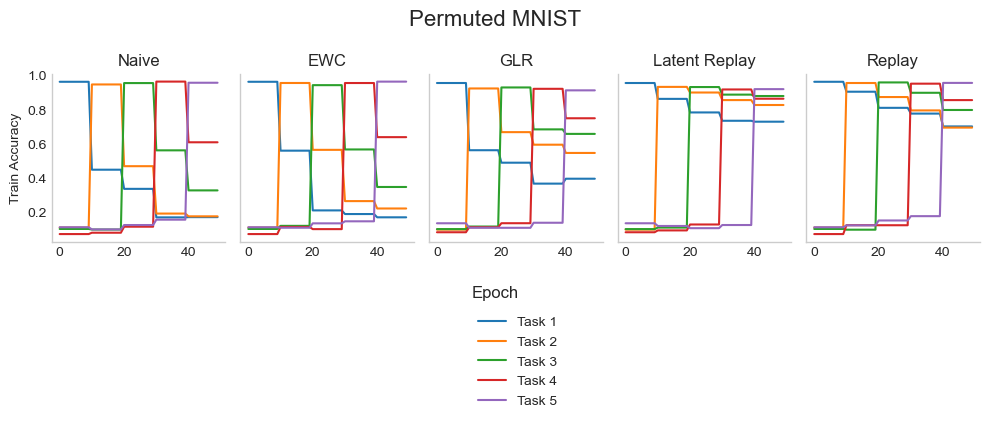

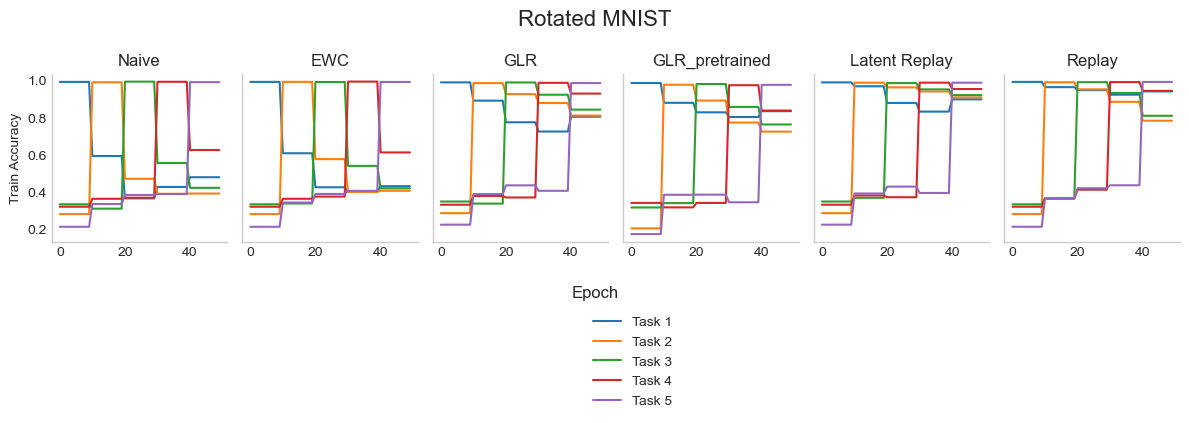

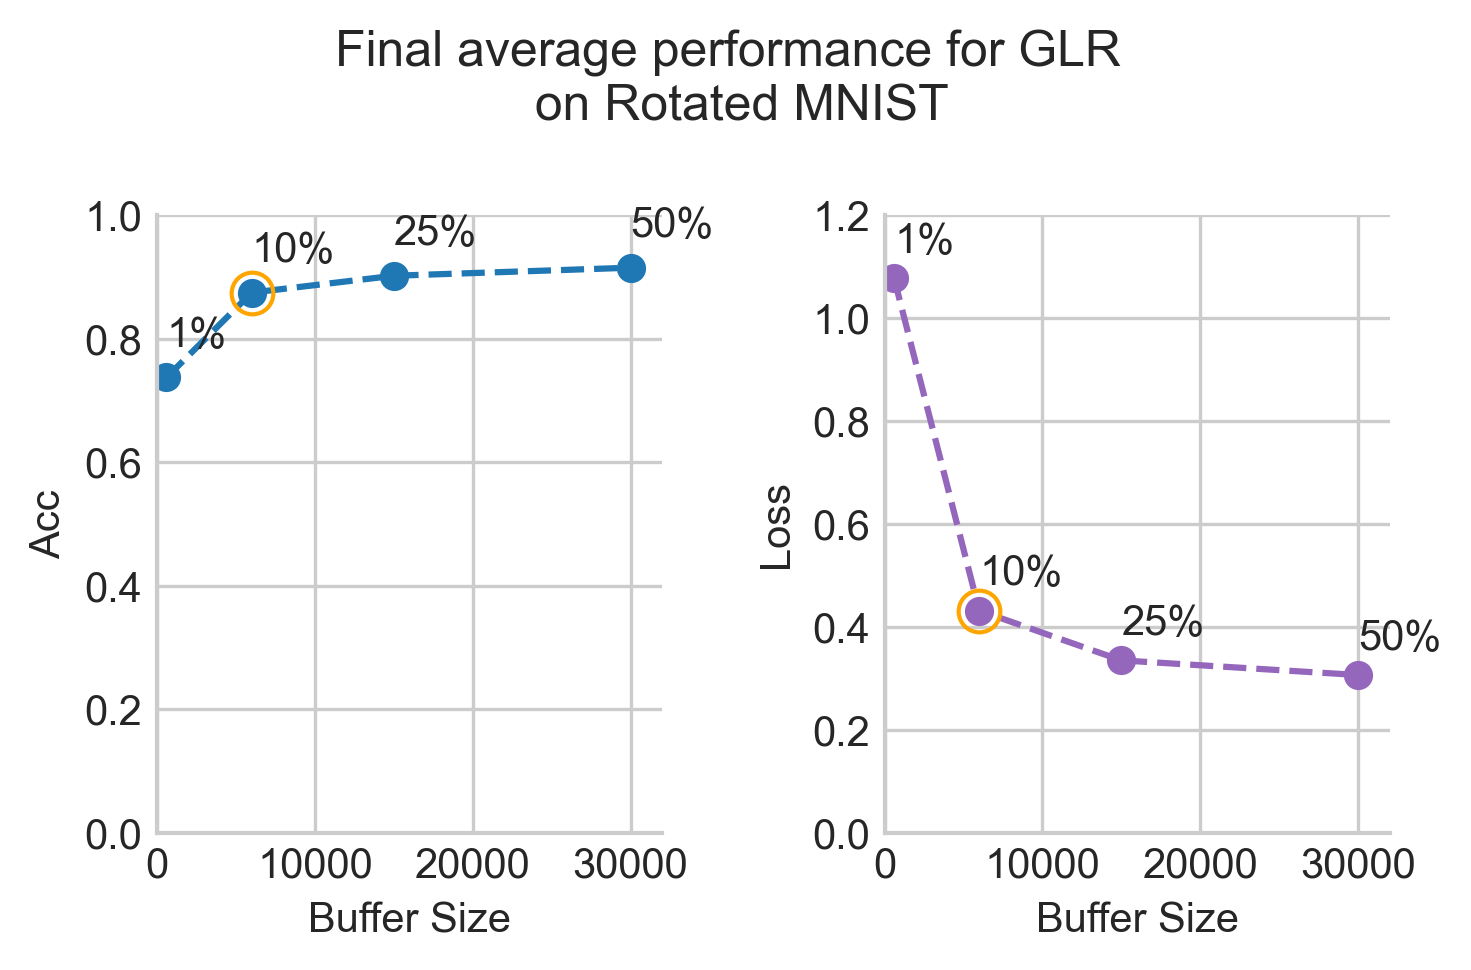

In [2]:
from src import plotting
import importlib; importlib.reload(plotting)
from src import plotting
plotting.plot_multiple_results()
plotting.plot_multiple_results(experiment='RotatedMNIST_archive')
plotting.plot_final_avg_results()

In [4]:
#res_p = plotting.results_to_df().to_latex()
#res_r = plotting.results_to_df(experiment='RotatedMNIST').to_latex()
res_buff = plotting.results_to_df(experiment='RotatedMNIST_buffer_size').to_latex()
print(res_buff)

\begin{tabular}{lrr}
\toprule
{} &  Final Avg Acc &  Final Avg Loss \\
\midrule
GLR\_15000 &        0.90192 &         0.33498 \\
GLR\_30000 &        0.91502 &         0.30648 \\
GLR\_600   &        0.73722 &         1.07844 \\
GLR\_6000  &        0.87462 &         0.43166 \\
\bottomrule
\end{tabular}



C:\Users\jacob\AppData\Local\Temp\ipykernel_27324\3896908686.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  res_buff = plotting.results_to_df(experiment='RotatedMNIST_buffer_size').to_latex()
